chemLTD demo analysis
=====================

In [1]:
import os
import sys
import glob
import yaml

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage
from scipy import signal


## DoMB demo

In [2]:
from domb.reg_type.wf_x2_m2 import WF_2x_2m as WF
from domb.fret.e_app import Eapp
from domb.red_green.wt_vs_mut import WTvsMut as WvM

In [3]:
reg_path = '08.tif'
reg = WF(img_path=reg_path, img_name=reg_path.split('.')[0], sigma=.25,
         soma_mask=False, soma_ext=200)  # processes masking parameters

### RG DoMB

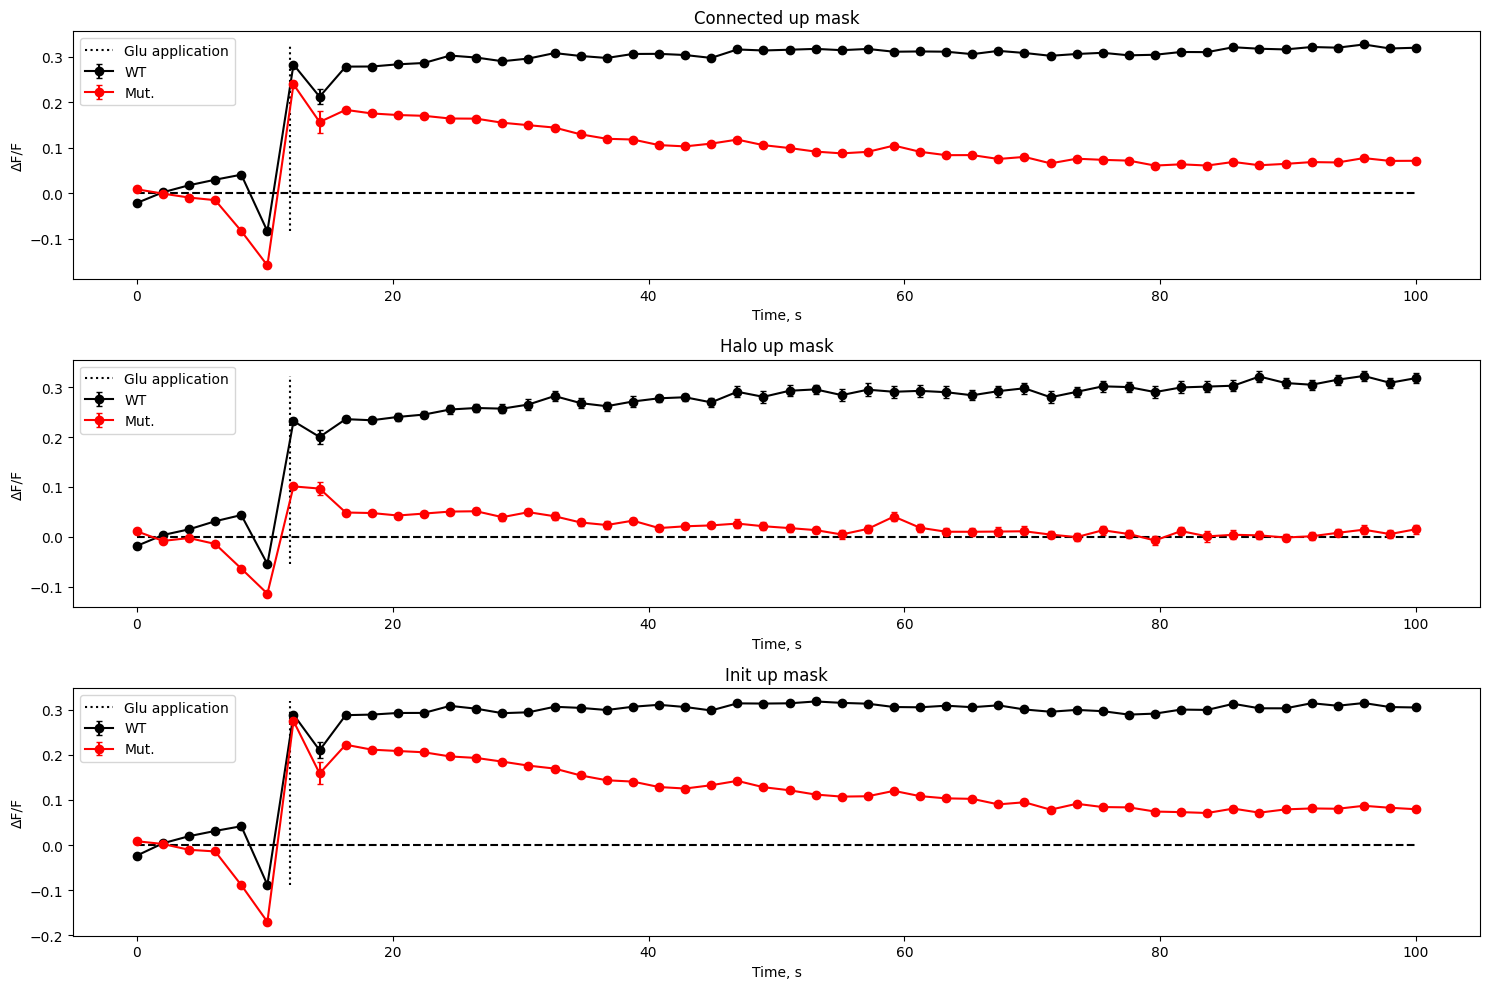

In [4]:
reg_RG = WvM(wt_img=reg.corr_cfp_img,
             mut_img=reg.corr_yfp_img,
             proc_mask=reg.proc_mask,
             sd_tolerance=2, base_frames=5, app_start=7, app_win=7)  # up mask calc parameters

reg_RG.df_mean_prof_pic(fsize=(15,10))

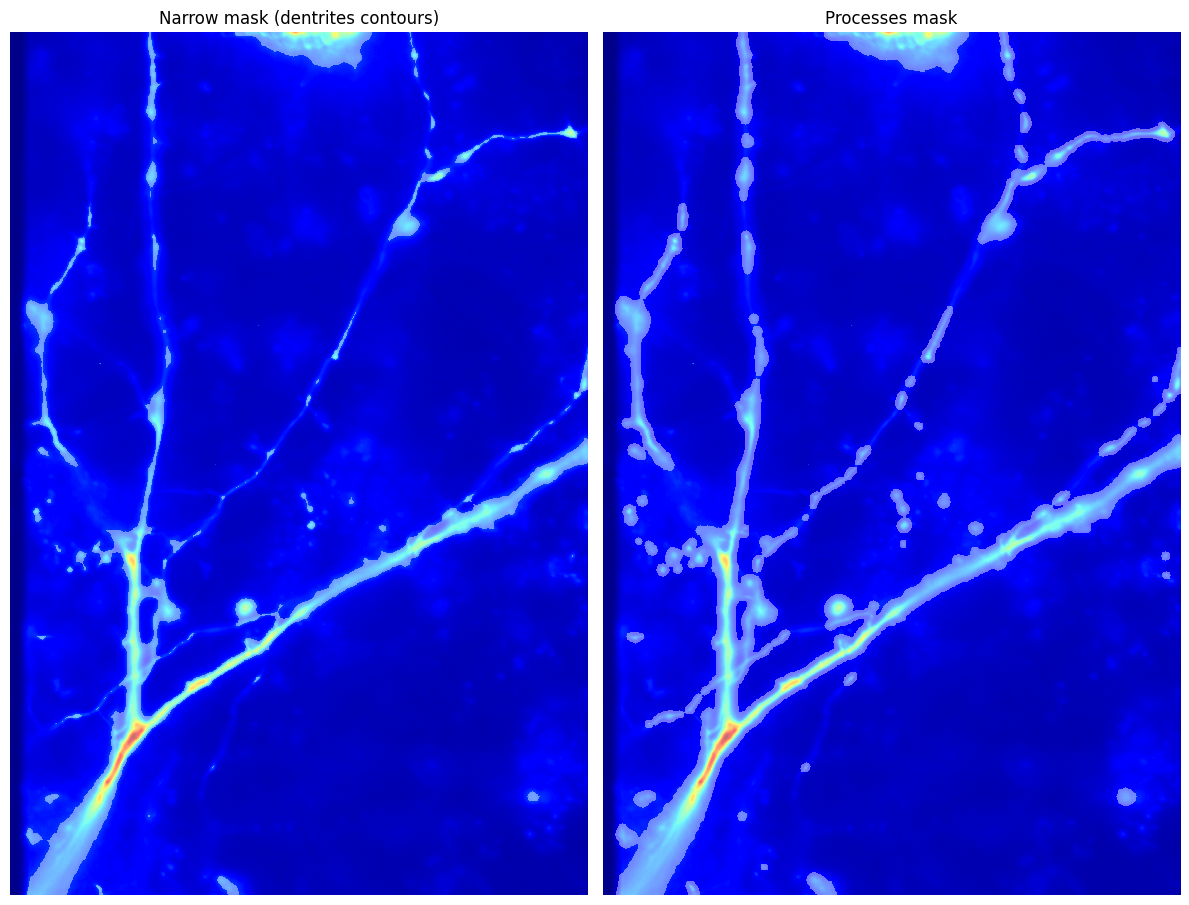

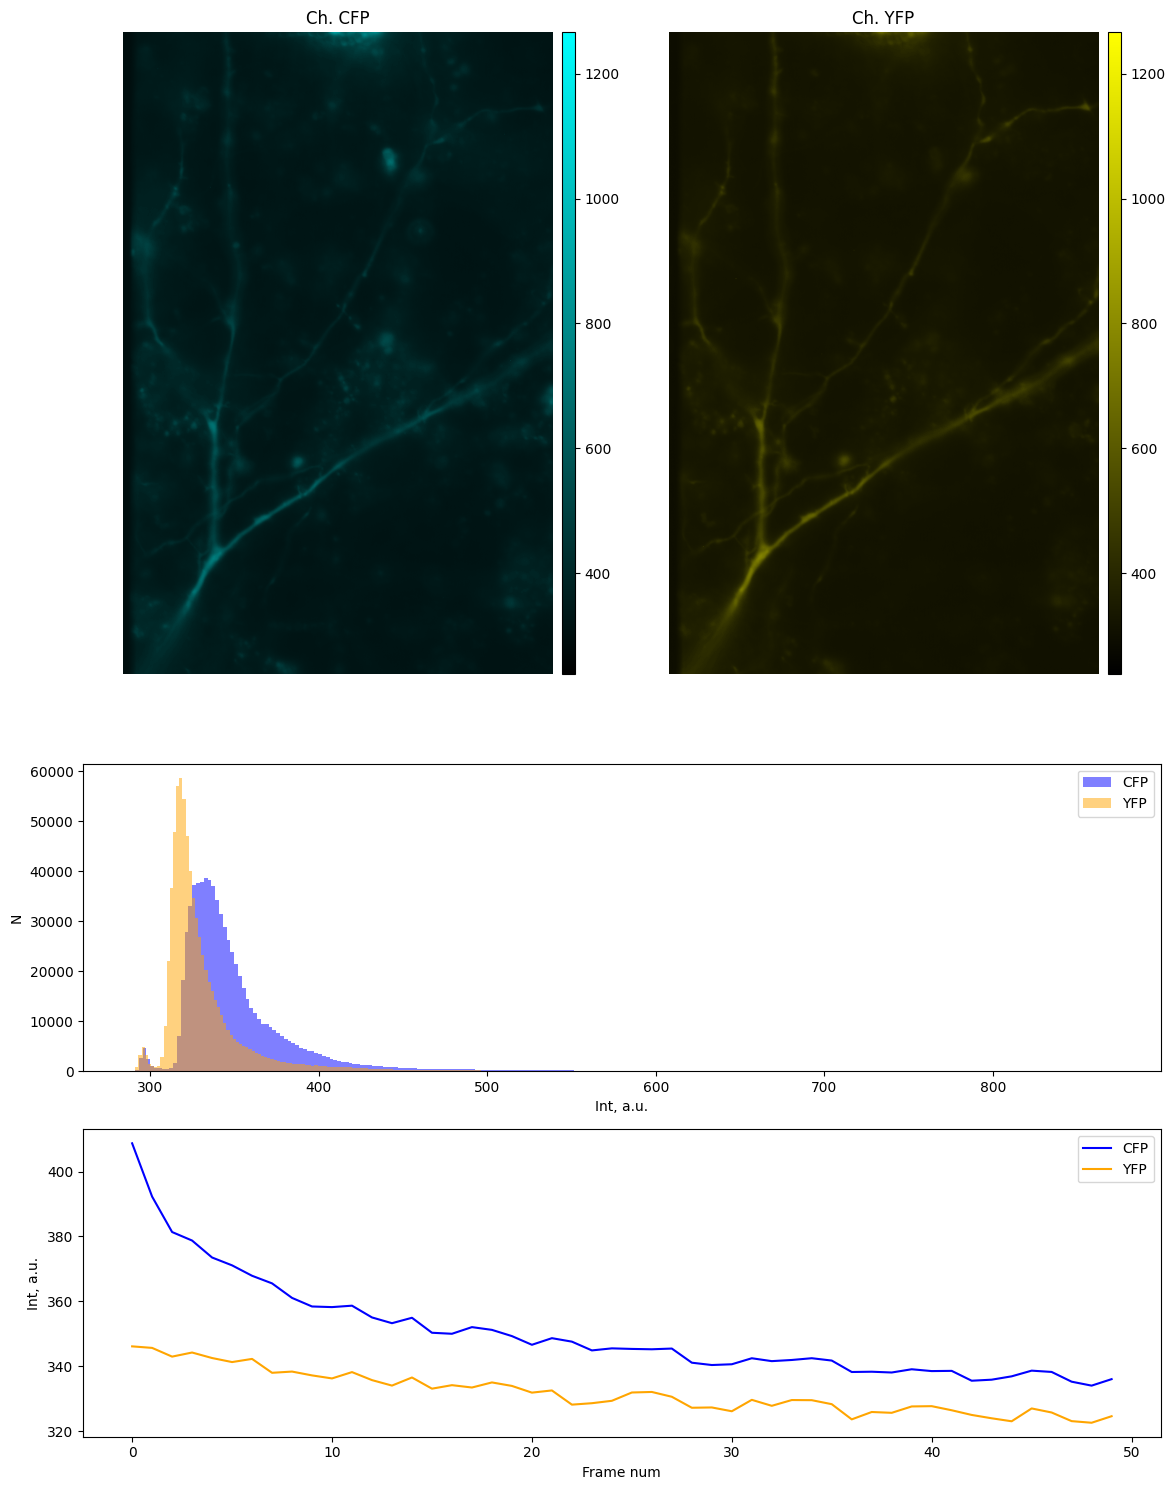

In [12]:
reg.processes_mask_pic()
reg.ch_pic()

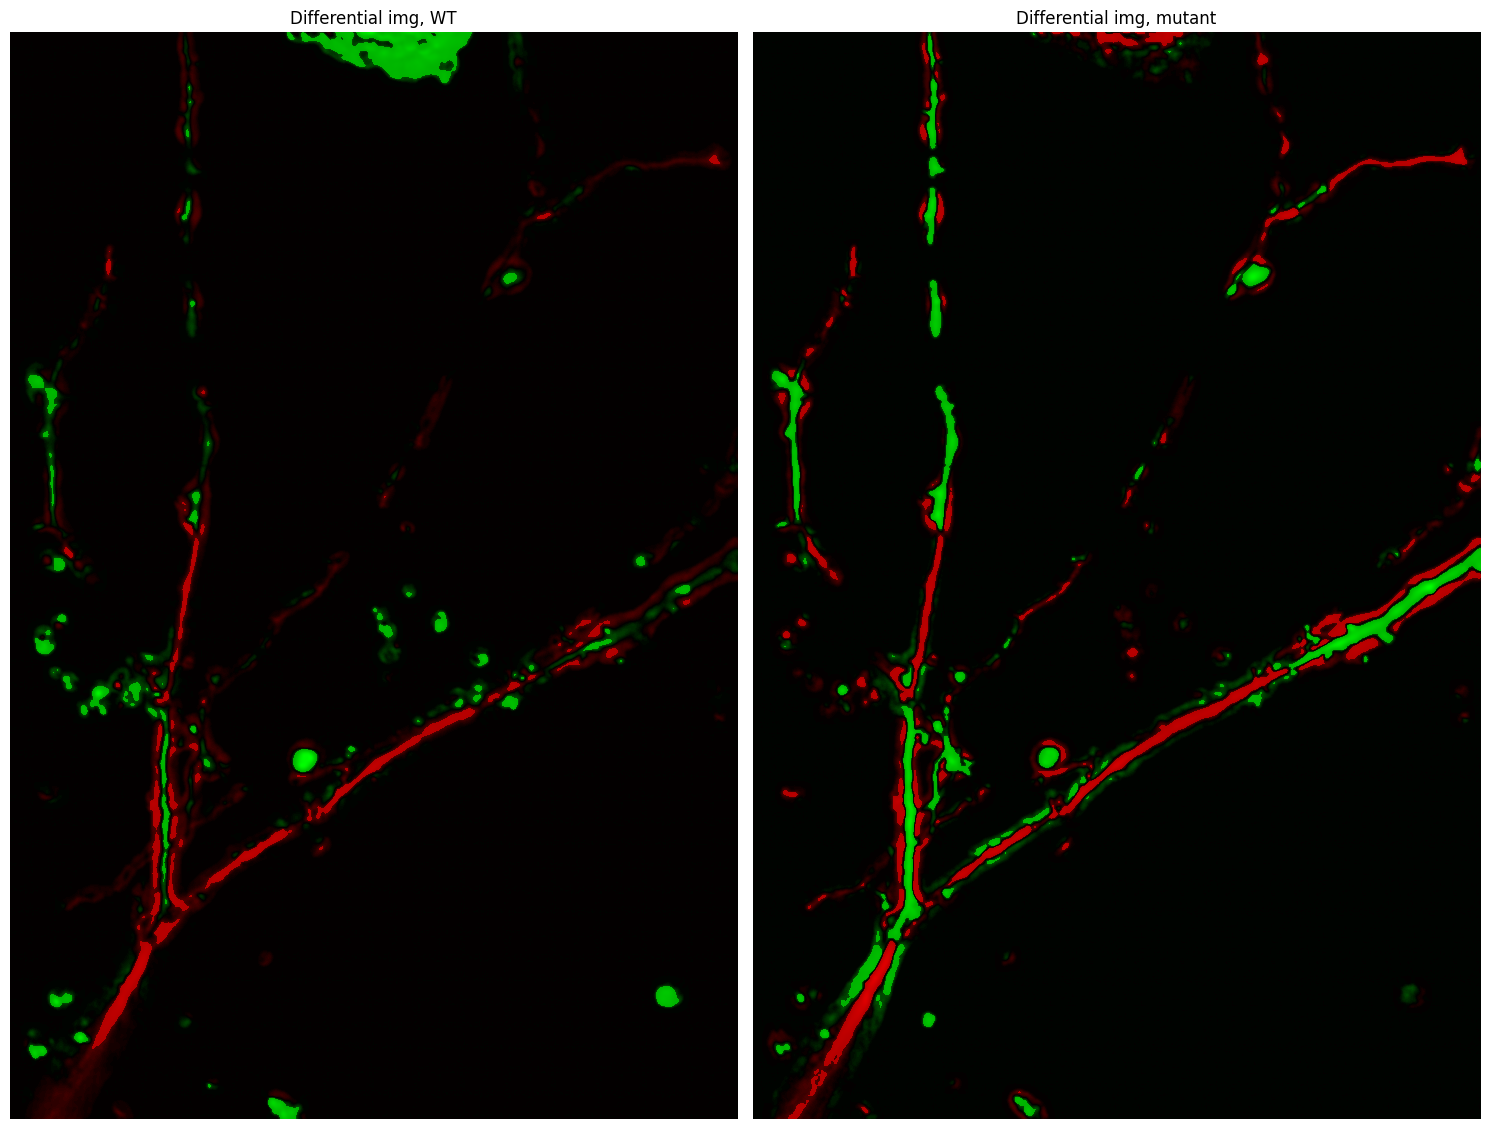

In [6]:
reg_RG.diff_img_pic()

### FRET DoMB

In [7]:
a = 0.144
b = 0.1292
c = 0.2458
d = 0.8506
abcd = [a, b, c, d]

G = 15.925

reg_FRET = Eapp(dd_img=reg.ch0_img,
                da_img=reg.ch1_img,
                ad_img=reg.ch2_img,
                aa_img=reg.ch3_img,
                abcd_list=abcd, G_val=G)

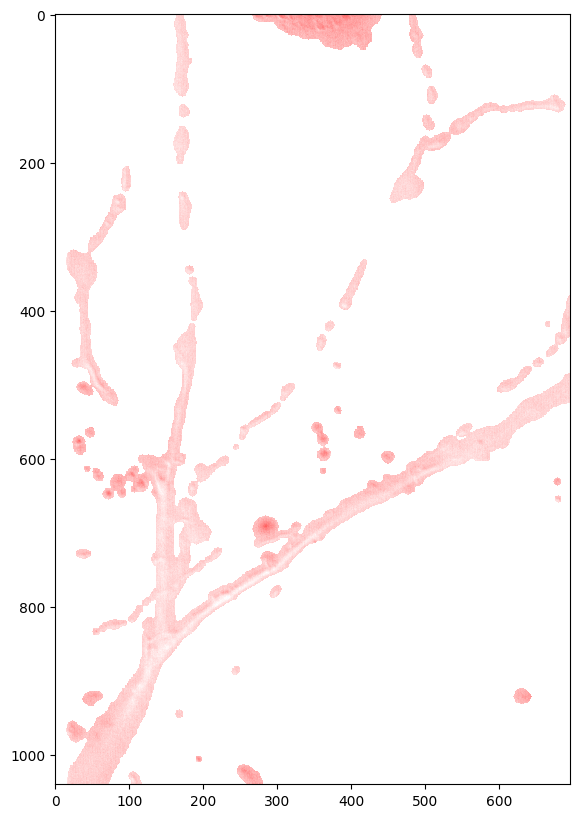

In [8]:
from domb.util.plot import CMaps 

FRET_frame = reg_FRET.R_img[30]

plt.figure(figsize=(10,10))
plt.imshow(ma.masked_where(~reg.proc_mask, FRET_frame),
           cmap='bwr', vmin=-np.max(np.abs(FRET_frame)), vmax=np.max(np.abs(FRET_frame)))

In [9]:
from domb.util import masking

conn_fret = masking.label_prof_arr_dict(input_labels=reg_RG.connected_up_label,
                                        input_img_series=reg_FRET.Ecorr_img,
                                        df_arr=False)
halo_fret = masking.label_prof_arr_dict(input_labels=reg_RG.halo_up_label, 
                                        input_img_series=reg_FRET.Ecorr_img,
                                        df_arr=False)
init_fret = masking.label_prof_arr_dict(input_labels=reg_RG.init_up_label,
                                        input_img_series=reg_FRET.Ecorr_img,
                                        df_arr=False)

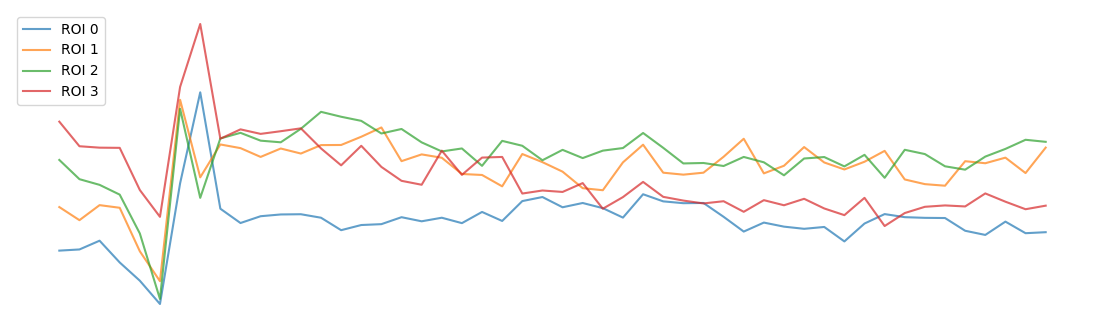

In [10]:
arr = reg_RG.mut_halo_df_arr


plt.figure(figsize=(14, 4))

shift = 0
for num_ROI in range(arr.shape[0]):
    prof_ROI = arr[num_ROI]
    plt.plot(prof_ROI+shift, alpha=.7, label=f'ROI {num_ROI}')
    shift += 0.05

# for line_name in line_dict:
#     line_lim = line_dict[line_name]
#     plt.plot(line_lim, [-0.4] * len(line_lim), label=line_name, linewidth=4)

# plt.vlines(x=[-20], ymin=[-0.1], ymax=[0.0], linewidth=3, color='k')
# plt.text(x=-30, y=-0.2, s="0.1", size=15, rotation=90.)

# plt.hlines(y=[-0.75], xmin=[-2], xmax=[8], linewidth=3, color='k')
# plt.text(x=30, y=-1.15, s="10 s", size=15)

plt.axis('off')
plt.legend(loc=2)
plt.show()

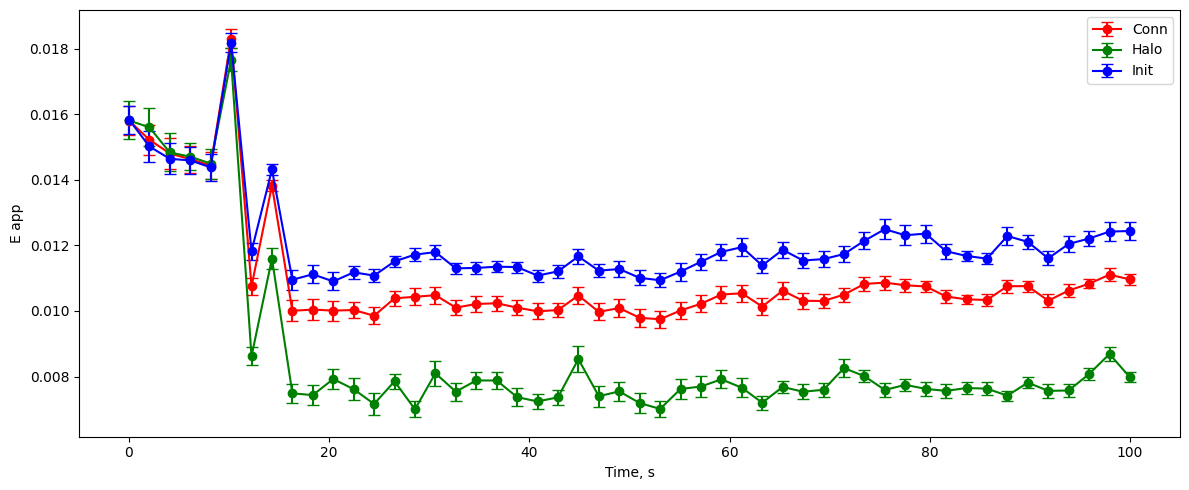

In [11]:
time_line = np.linspace(0, conn_fret[-1].shape[1]*2, num=conn_fret[-1].shape[1])
arr_stat = lambda x: (np.mean(x, axis=0),  np.std(x, axis=0)/np.sqrt(x.shape[1]))

conn_fret_mean, conn_fret_sem = arr_stat(conn_fret[-1])
halo_fret_mean, halo_fret_sem = arr_stat(halo_fret[-1])
init_fret_mean, init_fret_sem = arr_stat(init_fret[-1])

plt.figure(figsize=(12,5))

plt.errorbar(time_line, conn_fret_mean,
             yerr = conn_fret_sem,
             fmt ='-o', color='r', capsize=4, label='Conn')
plt.errorbar(time_line, halo_fret_mean,
             yerr = halo_fret_sem,
             fmt ='-o', color='g', capsize=4, label='Halo')
plt.errorbar(time_line, init_fret_mean,
             yerr = init_fret_sem,
             fmt ='-o', color='b', capsize=4, label='Init')

plt.xlabel('Time, s')
plt.ylabel('E app')
plt.tight_layout()
plt.legend()